In [1]:
import tensorflow as tf
import numpy as np
#from utils import build_model
import pandas as pd
from tqdm import tqdm
import imageio
import matplotlib.pyplot as plt
import keras
from keras.layers import Conv2D, Dropout, Flatten, Dense
from keras.regularizers import l2
import statsmodels.api as sm
from utils import build_model, find_closest_element, Fy
from scipy.stats import norm

In [20]:
checkpoint_path = '../../../../data/models/mc_dropout_cil/export/'

In [ ]:
model = build_model()
model.load_weights(tf.train.latest_checkpoint(checkpoint_path))

In [ ]:
# all training images and paths
path_all_imgs = '../../../../commaai_code/02_write_shards_optional/cil_shards/df_paths.csv'
all_img_df = pd.read_csv(path_all_imgs)
all_img_df = all_img_df[np.abs(all_img_df['true_y']) < 40].reset_index()

In [ ]:
# extract Bzetas by reading in images and predicting
labels = []
preds = []
for i in tqdm(range(0,all_img_df.shape[0])): 
    img = imageio.imread(str(img_path_base + all_img_df.loc[i,'path']))[:,:,0:3]/255
    pred = model.predict(img.reshape(1,66,200,3))
    label = all_img_df.loc[i,'true_y']
    labels.append(label)       
    preds.append(pred)

# rearrange to arrays
labels = np.array(labels)
preds = np.array(preds)

In [ ]:
np.save('../../../../data/commaai/predictions/mc_dropout/y_preds_cil_no_mc.npy', preds)
np.save('../../../../data/commaai/predictions/mc_dropout/y_labels_cil_no_mc.npy', labels)

In [ ]:
np.mean((labels - preds.reshape(-1,))**2)

In [ ]:
np.mean(np.abs((labels - preds.reshape(-1,))))

In [ ]:
np.mean([(labels - preds.reshape(-1,)) <= 6])

In [ ]:
np.mean([(labels - preds.reshape(-1,)) <= 2])

In [ ]:
plt.scatter(labels, preds.reshape(-1,), alpha = 0.05)
plt.plot([-40,40], [-40,40], color = 'red', alpha = 0.1)

## MC-Dropout

In [9]:
mc_preds = np.append(np.load('../../../../data/commaai/predictions/mc_dropout/mc_preds_cil_y_1.npy'),
          np.load('../../../../data/commaai/predictions/mc_dropout/mc_preds_cil_y_2.npy')).reshape(-1,1000)

In [10]:
preds_mc_y = np.mean(mc_preds, axis = 1)

In [17]:
labels = np.load('../../../../data/commaai/predictions/mc_dropout/y_labels_cil.npy')
preds = np.load('../../../../data/commaai/predictions/mc_dropout/y_preds_cil.npy' )

In [12]:
preds_mc_y = preds_mc_y.reshape(94570,)

(array([1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
        0.0000e+00, 2.0000e+00, 0.0000e+00, 2.0000e+00, 3.0000e+00,
        4.0000e+00, 5.0000e+00, 4.0000e+00, 9.0000e+00, 2.0000e+00,
        8.0000e+00, 1.2000e+01, 1.5000e+01, 2.0000e+01, 3.7000e+01,
        2.2000e+01, 2.1000e+01, 2.2000e+01, 2.6000e+01, 2.0000e+01,
        2.3000e+01, 3.3000e+01, 3.7000e+01, 5.3000e+01, 6.4000e+01,
        8.4000e+01, 1.8900e+02, 4.5700e+02, 7.9400e+02, 1.2200e+03,
        1.4950e+03, 1.6130e+03, 1.5410e+03, 1.7600e+03, 2.2130e+03,
        2.3570e+03, 2.5580e+03, 3.4390e+03, 6.1450e+03, 1.1537e+04,
        1.6288e+04, 1.4570e+04, 7.4500e+03, 3.7480e+03, 2.6590e+03,
        2.4190e+03, 1.9540e+03, 1.7110e+03, 1.6340e+03, 1.5570e+03,
        1.1650e+03, 6.2000e+02, 2.7700e+02, 1.4900e+02, 1.1000e+02,
        7.9000e+01, 5.7000e+01, 5.0000e+01, 5.3000e+01, 2.5000e+01,
        3.5000e+01, 2.7000e+01, 2.4000e+01, 1.00

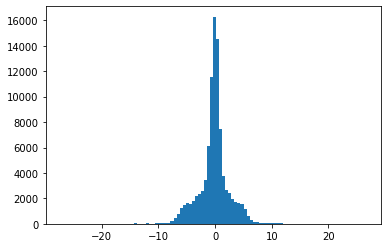

In [14]:
plt.hist(preds_mc_y.reshape(94570,), bins = 100)

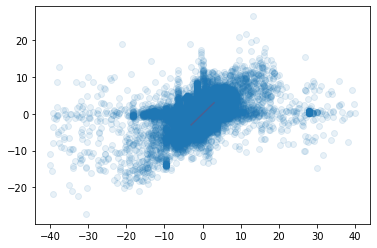

In [15]:
plt.scatter(labels, preds_mc_y, alpha = 0.1)
plt.plot([-3,3], [-3,3], color = 'red', alpha = 0.2)

In [18]:
print("Performance of models without and with uncertainty" +
     "\nMSE:" +
      "\nwithout uncertainty: " + str(np.mean((labels - preds.reshape(94570,))**2)) +
      "\nwith uncertainty: " + str(np.mean((labels - preds_mc_y.reshape(94570,))**2)) +
      "\nMAE:" +
      "\nwithout uncertainty: " + str(np.mean(np.abs(labels - preds.reshape(94570,)))) +
      "\nwith uncertainty: " + str(np.mean(np.abs(labels - preds_mc_y.reshape(94570,)))) +
      "\nAccuracy :" +
      "\nwithout uncertainty: " + str(np.mean([np.abs((labels - preds.reshape(94570,))) <= 6])) +
      "\nwith uncertainty: " + str(np.mean([np.abs((labels - preds_mc_y.reshape(94570,))) <= 6])) +
      "\nAccuracy II:" +
      "\nwithout uncertainty: " + str(np.mean([np.abs((labels - preds.reshape(94570,))) <= 2])) +
      "\nwith uncertainty: " + str(np.mean([(labels - preds_mc_y.reshape(94570,)) <= 2])) 
     )

Performance of models without and with uncertainty
MSE:
without uncertainty: 10.03036493888901
with uncertainty: 9.425808919101128
MAE:
without uncertainty: 1.6378203449922153
with uncertainty: 1.6014528043756997
Accuracy :
without uncertainty: 0.9531140953790843
with uncertainty: 0.9565929998942582
Accuracy II:
without uncertainty: 0.7851432801099715
with uncertainty: 0.8911599873109866


In [ ]:
plt.scatter(preds_l, preds_mc_y , alpha = 0.2)

In [ ]:
np.mean((preds_l.reshape(94570,) - preds_mc_z.reshape(94570,))**2)

In [ ]:
plt.scatter(labels, preds, alpha = 0.1)

In [ ]:
labels = np.array(labels)
preds = np.array(preds)